In [128]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
import math
from inspect import isfunction
from functools import partial
from tqdm.auto import tqdm
from einops import rearrange, repeat

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, einsum
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib

from sklearn.datasets import make_moons

In [130]:
FIG_SIZE = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
matplotlib.rcParams['figure.figsize'] = (FIG_SIZE, FIG_SIZE)

# Datasets

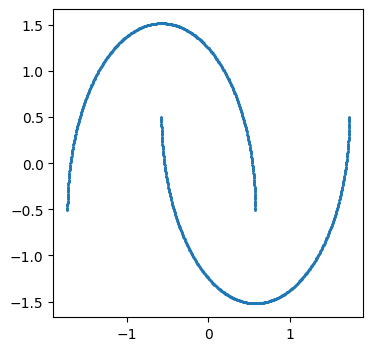

In [176]:
N_SAMPLES = 1000
BATCH_SIZE = 128

X, _ = make_moons(n_samples=N_SAMPLES)
X = (X - X.mean(axis=0)) / X.std(axis=0) # center and normalize
X = torch.tensor(X, dtype=torch.float32)
X = X.to(device)

dataloader = DataLoader(X, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], s=1)

# $\beta$ scheduler

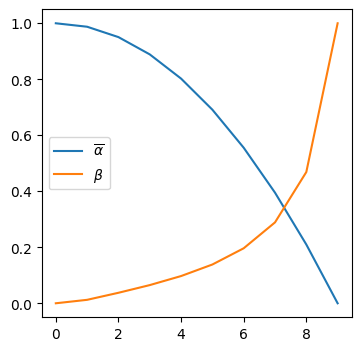

In [177]:
T = 10

# linear scheduling
# alpha_bar = torch.linspace(1, 0, T).to(device)

# cosine scheduling
# s = 1e-2
# f = lambda t_T: torch.cos((t_T + s)/(1 + s) * torch.pi/2)**2
# alpha_bar = f(torch.linspace(0, 1, T).to(device)) / f(torch.zeros(1))

# linear re-parametrization
alpha_bar = torch.linspace(1, 0, T).to(device)
alpha_bar = 1 - (1 - alpha_bar)**2


sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)

beta_0 = torch.zeros(1).to(device)
beta = 1 - (alpha_bar[1:] / alpha_bar[:-1])
beta = torch.cat([beta_0, beta])

assert len(alpha_bar) == len(beta) == T, "alpha_bar and beta should have the same length"
assert torch.allclose((1 - beta).cumprod(0), alpha_bar), "alpha_bar and beta are not consistent"

plt.plot(alpha_bar.cpu(), label="$\overline{\\alpha}$")
plt.plot(beta.cpu(), label="$\\beta$")
plt.legend();


# Forward

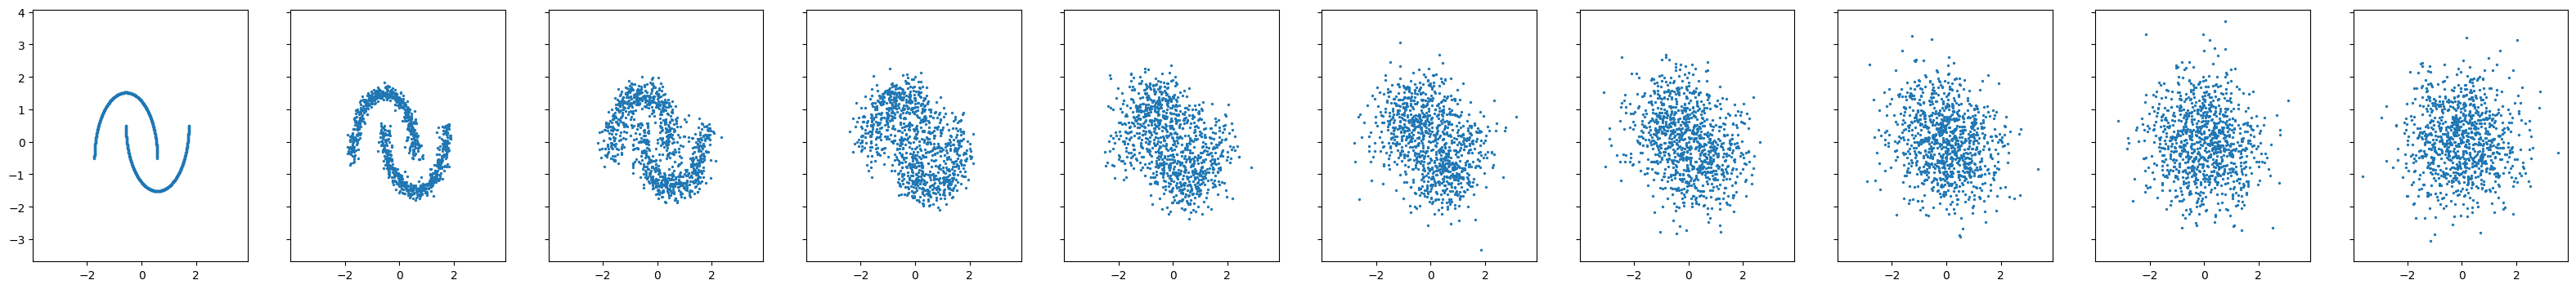

In [241]:
def forward(xs_0, time_steps):
    assert len(time_steps.shape) == 2, "time_steps should be a 2D tensor"
    assert len(xs_0.shape) == 2, "xs_0 should be a 2D tensor"
    n0, d = xs_0.shape
    n1, k = time_steps.shape
    assert n0 == n1, "xs_0 and time_steps should have the same batch size"

    xs_0 = repeat(xs_0, "n d -> n k d", k=k)
    time_steps = repeat(time_steps, "n k -> n k d", d=d)

    noise = torch.randn_like(xs_0)
    sqrt_alpha_bar_t = sqrt_alpha_bar[time_steps]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[time_steps]
    x_t = sqrt_alpha_bar_t * xs_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t, noise

time_steps = repeat(torch.arange(T), "k -> n k", n=N_SAMPLES).to(device)
xs_t, _ = forward(X, time_steps)
_, axes = plt.subplots(1, T, figsize=(FIG_SIZE * T, FIG_SIZE), sharex=True, sharey=True)
for t in range(T):
    axes[t].scatter(xs_t[:, t, 0], xs_t[:, t, 1], s=2)

# Network

In [242]:
class Model(nn.Module):
    def __init__(self, input_dim, nb_steps) -> None:
        super().__init__()
        self.nb_steps = nb_steps
        self.input_dim = input_dim
        self.nn = nn.Sequential(
            nn.Linear(input_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def t_embedding(self, t):
        t = repeat(t, "n -> n d", d=self.input_dim)
        t = 2 * t / (self.nb_steps-1) - 1 # rescale to [-1, 1]
        return t

    def forward(self, x, t):
        t = self.t_embedding(t)
        x = torch.cat([x, t], dim=-1)
        x = self.nn(x)
        return x

model = Model(input_dim=2, nb_steps=T).to(device)

x_test = torch.randn(10, 2)
t_test = torch.randn(10)
assert model(x_test, t_test).shape == x_test.shape

# Loss

In [243]:
def compute_loss(model, x_0, t):
    x_t, noise = forward(x_0, t)
    noise_pred = model(x_t, t)
    loss = F.mse_loss(noise_pred, noise)
    return loss

# Training

In [244]:
N_EPOCHS = 100

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in tqdm(range(N_EPOCHS)):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,)).to(device)
        loss = compute_loss(model, batch, t)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss = {loss.item()}")

  0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: time_steps should be a 2D tensor